# Using Variational Autoencoder to Generate Digital Numbers

Variational Autoencoders (VAEs) are very popular approaches to unsupervised learning of complicated distributions. In this example, we are going to use VAE to generate digital numbers.

![Standard Autoencoder](./standard_autoencoder.jpg)

In standard Autoencoder, we have an encoder network that takes in the original image and encode it into a vector of latent variables and a decoder network that takes in the latent vector and output an generated image that we hope to look similar to the original image.

![vae](./vae.jpg)

In VAE, we constrain the latent variable to be unit gaussian, so that we can sample latent variables from a unit gaussian distribution, then use the decoder network to generate images.

So, we get the architecture above. Instead of generate the latent varibles directly, the encoder network output a mean vector and a variance (or log-variance) vector, and the decoder takes the sampled latent vector to generate the output image. And we add penalty on the latent distribution's KL Divergence to a unit gaussian distribution.

## Define the Model

In [1]:
# a bit of setup
import numpy as np
from bigdl.dllib.nn.criterion import *
from bigdl.dllib.feature.dataset import mnist
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import Model
from bigdl.dllib.keras.utils import *
import datetime as dt

IMAGE_SIZE = 784
IMAGE_ROWS = 28
IMAGE_COLS = 28
IMAGE_CHANNELS = 1
latent_size = 2

from bigdl.dllib.utils.nncontext import *
sc = init_nncontext("Variational Autoencoder Example")

We are going to use a simple cnn network as our encoder and decoder. In decoder, we use SpatialFullConvolution (aka deconvolution or convolution transpose) layer to upsample the image to the original resolution.

In [2]:
def get_encoder(latent_size):
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_COLS, IMAGE_ROWS))
    
    #CONV
    conv1 = Convolution2D(16, 5, 5, input_shape=(IMAGE_CHANNELS, IMAGE_ROWS, IMAGE_COLS), border_mode='same',
                          subsample=(2, 2))(input0)
    relu1 = LeakyReLU()(conv1)
    conv2 = Convolution2D(32, 5, 5, input_shape=(16, 14, 14), border_mode='same', subsample=(2, 2))(relu1)
    relu2 = LeakyReLU()(conv2)  # 32,7,7
    reshape = Flatten()(relu2)
    
    #fully connected to output mean vector and log-variance vector
    reshape = Reshape([7*7*32])(relu2)
    z_mean = Dense(latent_size)(reshape)
    z_log_var = Dense(latent_size)(reshape)
    model = Model([input0],[z_mean,z_log_var])
    return model

In [3]:
def get_decoder(latent_size):
    input0 = Input(shape=(latent_size,))
    reshape0 = Dense(1568)(input0)
    reshape1 = Reshape((32, 7, 7))(reshape0)
    relu0 = Activation('relu')(reshape1)
    
    # use resize and conv layer instead of deconv layer
    resize1 = ResizeBilinear(14,14)(relu0)
    deconv1 = Convolution2D(16, 5, 5, subsample=(1, 1), activation='relu', border_mode = 'same', input_shape=(32, 14, 14))(resize1)
    resize2 = ResizeBilinear(28,28)(deconv1)
    deconv2 = Convolution2D(1, 5, 5, subsample=(1, 1), input_shape=(16, 28, 28), border_mode = 'same')(resize2)
    outputs = Activation('sigmoid')(deconv2)
    
    model = Model([input0],[outputs])
    return model

In [4]:
def get_autoencoder(latent_size):
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_COLS, IMAGE_ROWS))
    encoder = get_encoder(latent_size)(input0)
    sample = GaussianSampler()(encoder)
    decoder_model = get_decoder(latent_size)
    decoder = decoder_model(sample)
    model = Model([input0],[encoder,decoder])
    return model,decoder_model

In [5]:
autoencoder,decoder_model = get_autoencoder(2)

creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasLeakyReLU
creating: createZooKerasConvolution2D
creating: createZooKerasLeakyReLU
creating: createZooKerasFlatten
creating: createZooKerasReshape
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createZooKerasGaussianSampler
creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasReshape
creating: createZooKerasActivation
creating: createZooKerasResizeBilinear
creating: createZooKerasConvolution2D
creating: createZooKerasResizeBilinear
creating: createZooKerasConvolution2D
creating: createZooKerasActivation
creating: createZooKerasModel
creating: createZooKerasModel


## Get the MNIST Dataset

In [6]:
def get_mnist(sc, mnist_path):
    (train_images, train_labels) = mnist.read_data_sets(mnist_path = "/tmp/mnist", "train")
    train_images = np.reshape(train_images, (60000, 1, 28, 28))
    rdd_train_images = sc.parallelize(train_images)

    rdd_train_sample = rdd_train_images.map(lambda img:
                                        Sample.from_ndarray(
                                        (img > 128) * 1.0,
                                        [(img > 128) * 1.0, (img > 128) * 1.0]))
    return rdd_train_sample

In [7]:
mnist_path = "/tmp/mnist" # please replace this

train_data = get_mnist(sc, mnist_path)
# (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')


## Define our Training Objective

The `size_average` parameter in BCECriterion should be False, because when `size_average` is True, the negative_log_likelyhood computed in BCECriterion is average over each observations **as well as dimensions**, while in the `KLDCriterion` the KL-Divergence is **sumed over each observations**, the loss woule be wrong.

In [8]:
batch_size = 100
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0)
criterion.add(BCECriterion(size_average=False), 1.0/batch_size)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createBCECriterion


## Compile the Model

In [9]:
autoencoder.compile(optimizer=Adam(0.001), loss=criterion)

import os
if not os.path.exists("./log"):
    os.makedirs("./log")
                
app_name='vae-digits-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
autoencoder.set_tensorboard(log_dir='./log/',app_name=app_name)

print("Saving logs to ", app_name)

creating: createAdam
('Saving logs to ', 'vae-digits-20180607-162346')


## Start Training

This step may take a while depending on your system.

In [10]:
autoencoder.fit(x=train_data,
                batch_size=batch_size,
                nb_epoch = 6)

Let's show the learning curve.

In [11]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import datetime as dt



Populating the interactive namespace from numpy and matplotlib


creating: createTrainSummary


Text(0.5,1,'loss')

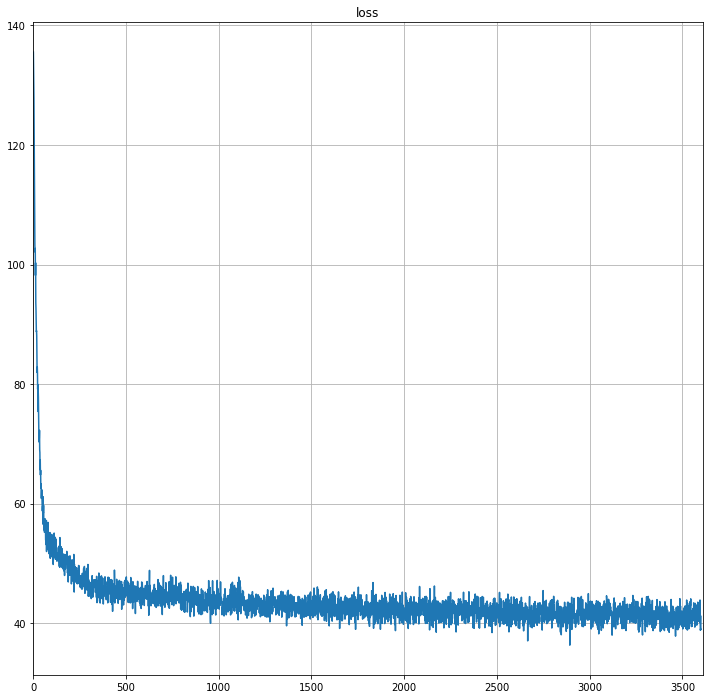

In [12]:
train_summary = TrainSummary('./log/', app_name)
loss = np.array(train_summary.read_scalar("Loss"))
plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

You can also open tensorboard to see this curve.

## Sample Some Images from the Decoder

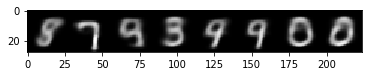

In [16]:
from matplotlib.pyplot import imshow

img = np.column_stack([decoder_model.forward(np.random.randn(1,2)).reshape(28,28) for s in range(8)])
imshow(img, cmap='gray')

## Explore the Latent Space

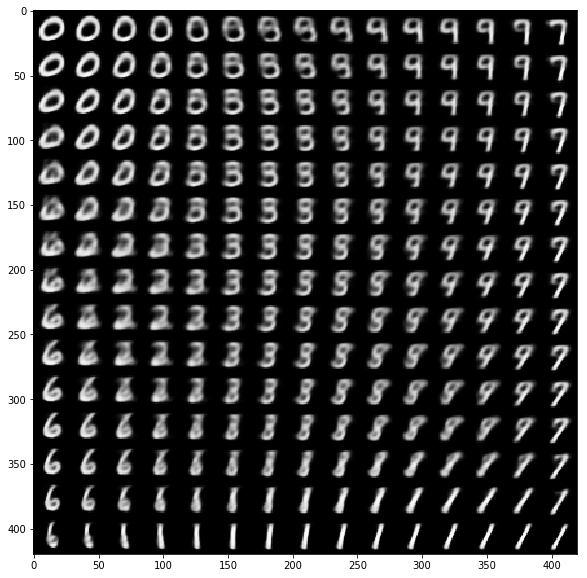

In [19]:
# This code snippet references this keras example (https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_model.forward(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()